In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import RandomizedSearchCV


In [2]:
data = pd.read_csv('Customer-Churn.csv')
data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,No,Yes,Yes,Yes,Yes,One year,84.80,1990.5,No
7039,Female,0,Yes,Yes,72,Yes,No,Yes,Yes,No,Yes,Yes,One year,103.20,7362.9,No
7040,Female,0,Yes,Yes,11,No,Yes,No,No,No,No,No,Month-to-month,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,No,No,No,No,No,No,Month-to-month,74.40,306.6,Yes


# build a model without handeling data imbalance

In [3]:
data.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [4]:
# change totalcharges to to numeric column, should be float
data['TotalCharges']=pd.to_numeric(data['TotalCharges'], errors='coerce')#, error='raise', downcast='float')

In [5]:
data['TotalCharges'].isnull().sum() # it couldnt transform 11 values

11

In [6]:
# no other column has Nan values
nulls_percent_df = pd.DataFrame(data.isna().sum()/len(data)).reset_index()
nulls_percent_df.columns = ['column_name', 'nulls_percentage']
nulls_percent_df[nulls_percent_df['nulls_percentage']!=0]

,column_name,nulls_percentage
14,TotalCharges,0.001562


/Users/test/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


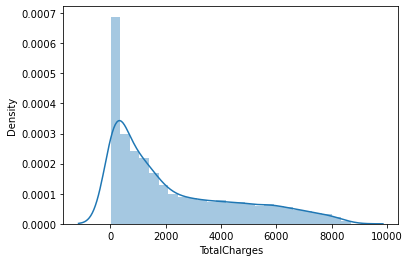

In [7]:
# look at distribrution of total charges
sns.distplot(data["TotalCharges"])
plt.show()

In [8]:
#gonna fill Nans values with mean
data['TotalCharges'] = data["TotalCharges"].fillna(np.mean(data['TotalCharges']))
data['TotalCharges'].isnull().sum()

0

In [9]:
#get target, and turn it into binary 1 yes 0 No
data['Churn']=data.Churn.map(dict(Yes=1, No=0))
y=data['Churn']
y

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int64

In [10]:
# x-y split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42)

In [11]:
# select the efatures we want
X_train=X_train[['tenure','SeniorCitizen','MonthlyCharges','TotalCharges']].copy()
X_test=X_test[['tenure','SeniorCitizen','MonthlyCharges','TotalCharges']].copy()

In [12]:
X_test

,tenure,SeniorCitizen,MonthlyCharges,TotalCharges
185,1,0,24.80,24.80
2715,41,0,25.25,996.45
3825,52,0,19.35,1031.70
1807,1,0,76.35,76.35
132,67,0,50.55,3260.10
...,...,...,...,...
5522,1,0,70.15,70.15
6377,1,0,44.65,44.65
5500,60,0,60.50,3694.45
2392,20,0,90.70,1781.35


In [13]:
# fit minmax scaler on x train 
transformer = MinMaxScaler().fit(X_train)

#transform xtrain and xtest
X_train_norm = transformer.transform(X_train)
X_test_norm=transformer.transform(X_test)

#create dataframe
df_X_train = pd.DataFrame(X_train_norm, index=X_train.index, columns=X_train.columns) #keep indices
df_X_test = pd.DataFrame(X_test_norm, index=X_test.index, columns=X_test.columns) #keep indices

In [14]:
df_X_test

,tenure,SeniorCitizen,MonthlyCharges,TotalCharges
185,0.013889,0.0,0.065272,0.000692
2715,0.569444,0.0,0.069756,0.112814
3825,0.722222,0.0,0.010962,0.116882
1807,0.013889,0.0,0.578974,0.006641
132,0.930556,0.0,0.321873,0.374025
...,...,...,...,...
5522,0.013889,0.0,0.517190,0.005925
6377,0.013889,0.0,0.263079,0.002983
5500,0.833333,0.0,0.421026,0.424146
2392,0.277778,0.0,0.721973,0.203387


In [15]:
#fit logistic regression on train setf
from sklearn.linear_model import LogisticRegression 


classification = LogisticRegression(random_state=0).fit(df_X_train, y_train)

In [16]:
#evaluate score on test set
predictions = classification.predict(df_X_test)
classification.score(df_X_test,y_test)

0.7950780880265026

In [17]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [18]:
from sklearn.metrics import confusion_matrix
C=confusion_matrix(y_test, predictions)
C

array([[1425,  114],
       [ 319,  255]])

<AxesSubplot:>

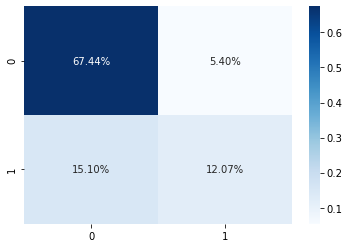

In [19]:
sns.heatmap(C/np.sum(C), annot=True, 
            fmt='.2%', cmap='Blues')

# build a model but handeling data imbalance

In [20]:
# check imbalance
y.value_counts()
#we have a lot more people which dont churn than thsoe that do

0    5174
1    1869
Name: Churn, dtype: int64

In [21]:
#get features and target
df_X_train_target=pd.concat([df_X_train, y_train], axis=1)
display(df_X_train_target)

#split data into the two traget categroies
category0_Xtrain = df_X_train_target[df_X_train_target['Churn'] == 0]
category1_Xtrain = df_X_train_target[df_X_train_target['Churn'] == 1]

,tenure,SeniorCitizen,MonthlyCharges,TotalCharges,Churn
1695,0.750000,0.0,0.522671,0.432864,0
1095,0.013889,0.0,0.620827,0.007126,0
3889,0.180556,0.0,0.010463,0.027793,0
3667,0.333333,1.0,0.780269,0.259018,0
2902,0.083333,1.0,0.556552,0.049862,0
...,...,...,...,...,...
3772,0.013889,0.0,0.764823,0.008793,1
5191,0.319444,0.0,0.725959,0.251500,0
5226,0.166667,0.0,0.028899,0.033147,0
5390,0.166667,1.0,0.809168,0.136320,1


### downsample: only for train set, and than predict "real" data which is test set

In [22]:
#downsample high amount of 0's in train set
category_0_undersampled = resample(category0_Xtrain, 
                                   replace=False, 
                                   n_samples = len(category1_Xtrain))

In [23]:
category_0_undersampled 

,tenure,SeniorCitizen,MonthlyCharges,TotalCharges,Churn
2373,0.916667,0.0,0.310414,0.373073,0
255,0.930556,0.0,0.411560,0.471394,0
886,0.097222,1.0,0.658695,0.068180,0
2735,0.722222,1.0,0.545092,0.439759,0
6,0.305556,0.0,0.706029,0.222779,0
...,...,...,...,...,...
1692,0.541667,0.0,0.069756,0.107195,0
6165,0.055556,1.0,0.522172,0.031739,0
302,0.055556,0.0,0.718984,0.038986,0
1574,0.208333,0.0,0.013951,0.029056,0


In [24]:
#concat undersampled category and other category
data_down_train=pd.concat([category_0_undersampled, category1_Xtrain], axis=0)

In [25]:
data_down_train['Churn'].value_counts() #same amount of samples

0    1295
1    1295
Name: Churn, dtype: int64

In [26]:
y_down=data_down_train['Churn']# get target
data_down_train.drop('Churn', axis=1, inplace=True) # drop target

In [27]:
data_down_train

,tenure,SeniorCitizen,MonthlyCharges,TotalCharges
2373,0.916667,0.0,0.310414,0.373073
255,0.930556,0.0,0.411560,0.471394
886,0.097222,1.0,0.658695,0.068180
2735,0.722222,1.0,0.545092,0.439759
6,0.305556,0.0,0.706029,0.222779
...,...,...,...,...
6231,0.013889,1.0,0.579472,0.006647
5334,0.680556,0.0,0.893871,0.608631
3092,0.013889,0.0,0.068261,0.000727
3772,0.013889,0.0,0.764823,0.008793


In [28]:
#fit logistic regression on downsampled train set


classification = LogisticRegression(random_state=0).fit(data_down_train, y_down)

In [29]:
y_test.value_counts() #our test data is unbalanced 

0    1539
1     574
Name: Churn, dtype: int64

In [30]:
#evaluate score on not balanced test set
predictions = classification.predict(df_X_test)
classification.score(df_X_test,y_test)

0.738760056791292

In [31]:
#downsampling worsened the accuracy by approximately 0.06

In [32]:
confusion_matrix(y_test, predictions)

array([[1127,  412],
       [ 140,  434]])

In [33]:
# bias was previously towards zero since there were the majoirty

#now we detect more of the 1#s ( people who would churn) but also lots of false postive (so people we predict chrun but dont)

### oversample

In [34]:
#upsample low amount of 1's
category_1_oversampled = resample(category1_Xtrain, 
                                  replace=True, 
                                  n_samples = len(category0_Xtrain))

In [35]:
data_upsampled = pd.concat([category0_Xtrain, category_1_oversampled], axis=0)

In [36]:
#before
df_X_train_target['Churn'].value_counts()

0    3635
1    1295
Name: Churn, dtype: int64

In [37]:
#after
data_upsampled['Churn'].value_counts() #same amount of samples

0    3635
1    3635
Name: Churn, dtype: int64

In [38]:
y_up=data_upsampled['Churn']# get target
data_upsampled.drop('Churn', axis=1, inplace=True) # drop target

In [39]:
#fit logistic regression on downsampled train set


classification = LogisticRegression(random_state=0).fit(data_upsampled,y_up)

In [40]:
#evaluate score on not balanced test set
predictions = classification.predict(df_X_test)
classification.score(df_X_test,y_test)

0.735447231424515

In [41]:
C=confusion_matrix(y_test, predictions)
C

array([[1112,  427],
       [ 132,  442]])

<AxesSubplot:>

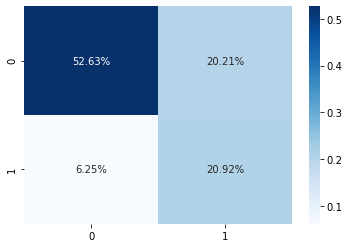

In [42]:
sns.heatmap(C/np.sum(C), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
# bias was previously towards zero since there were the majoirty

#now we detect more of the 1#s (20%, people who would churn) but also lots of false postive (so people we predict chrun but dont)


# optimize hyperparameters with grid or random search


In [73]:
penalty=['none','l1','l2','elasticnet']#default is l2
C=[0.0001, 0.001, 0.01, 0.11, 10, 100, 1000]#default is 1
solver=['newton-cg','lbfgs','liblinear','sag','saga'] #default is lbfgs


random_grid = {'penalty':penalty,
               'C': C,
               'solver': solver}

In [85]:

model = LogisticRegression()
random_search = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter=28, cv = 5, n_jobs = 100)

In [86]:
random_search.fit(df_X_train, y_train)
#there are error messages because some penalty dont work with some solvers

/Users/test/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/test/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/test/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1471, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

--------------------------------------------------------------------------------
15

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=28, n_jobs=100,
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.11, 10,
                                              100, 1000],
                                        'penalty': ['none', 'l1', 'l2',
                                                    'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']})

In [87]:
random_search.best_params_

{'solver': 'newton-cg', 'penalty': 'l2', 'C': 10}

In [88]:
random_search.best_score_

#so there is not really an improvement trying hyper parameter tuning here


0.7908722109533469

In [ ]:
#had a first run with less jobs didnt

In [84]:
#fit logistic regression on train set
classification = LogisticRegression(solver='saga',penalty='l1',C=0.11,random_state=0).fit(df_X_train, y_train)

In [83]:
#evaluate score on test set
predictions = classification.predict(df_X_test)
classification.score(df_X_test,y_test)

0.7941315664931378

In [ ]:
# baseline score was 0.7950780880265026 from the first model without any hyperparameter

In [ ]:
#run with more jobs

In [89]:
#fit logistic regression on train set
classification = LogisticRegression(solver='newton-cg',penalty='l2',C=10,random_state=0).fit(df_X_train, y_train)

In [90]:
#evaluate score on test set
predictions = classification.predict(df_X_test)
classification.score(df_X_test,y_test)

0.7936583057264552

In [ ]:
###unfortunately no real improvement